In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import LabelEncoder
import pymongo
import pandas as pd
import numpy as np
import re
from tqdm.notebook import tqdm
import os

In [2]:
client_mongo = pymongo.MongoClient("mongodb://127.0.0.1:27017/")
db = client_mongo["off"]
products = db["products"]
classified_products = db["classified_products"]

In [3]:
data = list(classified_products.find())
df_classified_products = pd.DataFrame(data)
df_classified_products.head()

,_id,product_name,category,code_bar
0,66df51e157d2c9919ae94ebd,Hot Dog Relish,Condiments et sauces,0000013631062
1,66df51e157d2c9919ae94ebe,Chocolat,Produits sucrés,0000018568011
2,66df51e157d2c9919ae94ebf,Tripoux,Plats préparés,0000018927207
3,66df51e157d2c9919ae94ec0,Côtes du Rhône Villages 2014,Alcool,0000020004552
4,66df51e157d2c9919ae94ec1,Butter Croissants,Plats préparés,0000020039127


In [4]:
categories = set(df_classified_products["category"])
print(len(categories), "categories found")
categories

16 categories found


{'Alcool',
 'Boissons',
 'Boissons sucrées',
 'Condiments et sauces',
 'Eau',
 'Fruits et légumes',
 'Féculents',
 'Féculents et légumes secs (légumineuses)',
 'Matières grasses',
 'Plats préparés',
 'Produits laitiers',
 'Produits sucrés',
 'Sel',
 'UNDEFINED',
 'Viande, poisson et fruits de mer',
 'Vitamines et minéraux'}

In [5]:
def get_category_or_zeros(code_bar):
    product = products.find_one({"_id": code_bar})
    if not product:
        return ""    
    category_old = product.get("categories_old", None)
    category = product.get("categories", None)

    if category_old:
        return category_old
    elif category:
        return category
    else:
        return [0] * len(categories)

df_classified_products["ingredients"] = df_classified_products["code_bar"].apply(
    lambda x: products.find_one({"_id": x}).get("ingredients_text", "") if products.find_one({"_id": x}) else ""
)

df_classified_products["category_vector"] = df_classified_products["code_bar"].apply(
    lambda x: get_category_or_zeros(x)
)

df_classified_products = df_classified_products[
    (df_classified_products["product_name"] != "") & (df_classified_products["ingredients"] != "")
]

print(len(df_classified_products))
df_classified_products.head()


99009


,_id,product_name,category,code_bar,ingredients,category_vector
3,66df51e157d2c9919ae94ec0,Côtes du Rhône Villages 2014,Alcool,0000020004552,"Vin rouge, sec. Contient des _sulfites_.","Boissons, Boissons alcoolisées, Vins, Vins fra..."
4,66df51e157d2c9919ae94ec1,Butter Croissants,Plats préparés,0000020039127,"Wheat flour, butter (cream), water, yeast, sug...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
5,66df51e157d2c9919ae94ec2,Wild Blueberry Muffins,Plats préparés,0000020039707,"Enriched wheat flour (wheat flour, malted barl...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
6,66df51e157d2c9919ae94ec3,Bolillos,Féculents,0000020042509,"Enriched wheat flour (wheat flour niacin, redu...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
7,66df51e157d2c9919ae94ec4,Biscuit,Plats préparés,0000020043070,"Enriched wheat flour (niacin, reduced iron, th...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"


In [6]:
df_classified_products["category_vector"] = df_classified_products["category_vector"].apply(
    lambda x: "" if x == [0] * len(categories) else x
)

print(f"{len(df_classified_products[df_classified_products["category_vector"] != ""])}/{len(df_classified_products)} products have a category")

88164/99009 products have a category


In [7]:
df_classified_products = df_classified_products[
    (df_classified_products["product_name"] != "") & 
    ((df_classified_products["ingredients"] != "") | (df_classified_products["category_vector"] != ""))
]

print(len(df_classified_products))
df_classified_products.head()


99009


,_id,product_name,category,code_bar,ingredients,category_vector
3,66df51e157d2c9919ae94ec0,Côtes du Rhône Villages 2014,Alcool,0000020004552,"Vin rouge, sec. Contient des _sulfites_.","Boissons, Boissons alcoolisées, Vins, Vins fra..."
4,66df51e157d2c9919ae94ec1,Butter Croissants,Plats préparés,0000020039127,"Wheat flour, butter (cream), water, yeast, sug...",
5,66df51e157d2c9919ae94ec2,Wild Blueberry Muffins,Plats préparés,0000020039707,"Enriched wheat flour (wheat flour, malted barl...",
6,66df51e157d2c9919ae94ec3,Bolillos,Féculents,0000020042509,"Enriched wheat flour (wheat flour niacin, redu...",
7,66df51e157d2c9919ae94ec4,Biscuit,Plats préparés,0000020043070,"Enriched wheat flour (niacin, reduced iron, th...",


In [8]:
import spacy

nlp_fr = spacy.blank('fr')
nlp_en = spacy.blank('en')
custom_stop_words = {
    'contient', 'ajouté', 'fabriqué', 'produit', 'avec', 'sans', 'dans', 'compris', 
    'préparé', 'utilisé', 'peut', 'contenir', 'ingrédients', 'et', 'ou', 'de', 'du', 
    'des', 'la', 'le', 'les', 'une', 'un', 'aux', 'à', 'pour', 'par', 'en', 'sur', 
    'au', 'avant', 'après', 'ce', 'cette', 'cet', 'ces', 'tout', 'tous', 'tout', 
    'sa', 'son', 'ses', 'leur', 'leurs', 'est', 'sont', 'été', 'sera', 'seront', 
    'a', 'ont', 'avait', 'fait', 'faire', 'incluant', 'inclut', 'comme', 'également', 
    'autres', 'autre', 'plus', 'moins', 'très', 'bien', 'mal', 'quantité', 'mélange', 
    'concentré', 'issu', 'issus', 'à base de', 'teneur', 'préparé', 'extrait', 'origine', 
    'composants', 'selon', 'réduit', 'haute', 'basse', 'qualité', 'frais', 'séché', 
    'congelé', 'emballé', 'transformé', 'réfrigéré', 'd’origine', 'de haute', 'de basse',
    'contenu', 'naturel', 'synthétique', 'additionné', 'modifié', 'dérivé', 'processus', 
    'procédé', 'avec', 'sans', 'naturellement', 'élaboré', 'utilisation', 'fabrication',
    'employé', 'fabriqué', 'obtenu', 'déshydraté', 'portion', 'portionné', 'mélangé', 
    'préparation', 'composition', 'complémentaire', 'provenant', 'extrait', 'adapté', "_sulfites_",
    'divers', 'façon', 'type', 'mode', 'conditionné', 'issu de', 'fabriqué dans', 'mis en'
}

stop_words_fr = nlp_fr.Defaults.stop_words
stop_words_en = nlp_en.Defaults.stop_words

stop_words = stop_words_fr.union(stop_words_en).union(custom_stop_words)

print(list(stop_words)[:10])

['within', '‘d', 'première', 'wherein', 'â', 'cette', 'huitième', 'onzième', 'i', 'nombreux']


In [9]:
def tokenize_and_remove_stopwords(text: str) -> list:
    text = re.sub(r'[^\w\s]', '', text)
    
    tokens = text.lower().split()
    
    filtered_tokens = [word for word in tokens if word not in stop_words]
    
    return filtered_tokens

tensor_df = df_classified_products.copy()

tensor_df["product_name_tokens"] = tensor_df["product_name"].apply(tokenize_and_remove_stopwords)
tensor_df["ingredients_tokens"] = tensor_df["ingredients"].apply(tokenize_and_remove_stopwords)
tensor_df["category_vector"] = tensor_df["category_vector"].apply(tokenize_and_remove_stopwords)
tensor_df.head()

,_id,product_name,category,code_bar,ingredients,category_vector,product_name_tokens,ingredients_tokens
3,66df51e157d2c9919ae94ec0,Côtes du Rhône Villages 2014,Alcool,0000020004552,"Vin rouge, sec. Contient des _sulfites_.","[boissons, boissons, alcoolisées, vins, vins, ...","[côtes, rhône, villages, 2014]","[vin, rouge, sec]"
4,66df51e157d2c9919ae94ec1,Butter Croissants,Plats préparés,0000020039127,"Wheat flour, butter (cream), water, yeast, sug...",[],"[butter, croissants]","[wheat, flour, butter, cream, water, yeast, su..."
5,66df51e157d2c9919ae94ec2,Wild Blueberry Muffins,Plats préparés,0000020039707,"Enriched wheat flour (wheat flour, malted barl...",[],"[wild, blueberry, muffins]","[enriched, wheat, flour, wheat, flour, malted,..."
6,66df51e157d2c9919ae94ec3,Bolillos,Féculents,0000020042509,"Enriched wheat flour (wheat flour niacin, redu...",[],[bolillos],"[enriched, wheat, flour, wheat, flour, niacin,..."
7,66df51e157d2c9919ae94ec4,Biscuit,Plats préparés,0000020043070,"Enriched wheat flour (niacin, reduced iron, th...",[],[biscuit],"[enriched, wheat, flour, niacin, reduced, iron..."


       product_name_len  ingredients_len
count      99009.000000     99009.000000
mean           4.029543        30.913604
std            2.049151        29.647230
min            0.000000         0.000000
25%            3.000000        11.000000
50%            4.000000        23.000000
75%            5.000000        40.000000
max           94.000000       407.000000


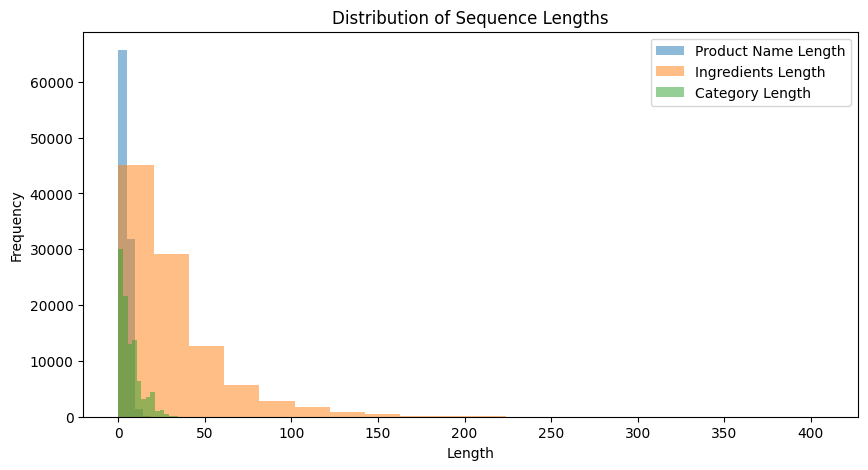

In [10]:
# Calculer la longueur des séquences de tokens pour les noms de produits et ingrédients
tensor_df['product_name_len'] = tensor_df['product_name_tokens'].apply(len)
tensor_df['ingredients_len'] = tensor_df['ingredients_tokens'].apply(len)

print(tensor_df[['product_name_len', 'ingredients_len']].describe())

import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
plt.hist(tensor_df['product_name_len'], bins=20, alpha=0.5, label='Product Name Length')
plt.hist(tensor_df['ingredients_len'], bins=20, alpha=0.5, label='Ingredients Length')
plt.hist(tensor_df['category_vector'].apply(len), bins=20, alpha=0.5, label='Category Length')
plt.legend(loc='upper right')
plt.xlabel('Length')
plt.ylabel('Frequency')
plt.title('Distribution of Sequence Lengths')
plt.show()


In [11]:
all_tokens = set(token for tokens in tensor_df['product_name_tokens'] for token in tokens)
all_tokens.update(token for tokens in tensor_df['ingredients_tokens'] for token in tokens)
all_tokens.update(token for tokens in tensor_df['category_vector'] for token in tokens)

In [12]:
from typing import Any


vocab = {token: idx for idx, token in enumerate(all_tokens, start=1)}
VOCAB_SIZE = len(vocab) + 1  # Ajout du padding (index 0)

def tokens_to_indices(tokens, vocab: dict, max_length: int):
    indices = [vocab[token] for token in tokens if token in vocab]
    if len(indices) > max_length:
        return indices[:max_length]
    else:
        return indices + [0] * (max_length - len(indices))


MAX_LEN_PRODUCT_NAME = 7
MAX_LEN_INGREDIENTS = 60
MAX_LEN_CATEGORY = 11

tensor_df['product_name_indices'] = tensor_df['product_name_tokens'].apply(lambda x: tokens_to_indices(x, vocab, MAX_LEN_PRODUCT_NAME))
tensor_df['ingredients_indices'] = tensor_df['ingredients_tokens'].apply(lambda x: tokens_to_indices(x, vocab, MAX_LEN_INGREDIENTS))
tensor_df['category_indices'] = tensor_df['category_vector'].apply(lambda x: tokens_to_indices(x, vocab, MAX_LEN_CATEGORY))
print(f"Vocab Size: {VOCAB_SIZE}")


Vocab Size: 33929


In [13]:
def verify_indices_within_vocab(indices, vocab_size):
    invalid_indices = [idx for idx in indices if not (0 <= idx < vocab_size)]
    if invalid_indices:
        raise ValueError(f"Des indices en dehors du vocabulaire trouvés : {invalid_indices}")

tensor_df['product_name_indices'].apply(lambda x: verify_indices_within_vocab(x, VOCAB_SIZE))
tensor_df['ingredients_indices'].apply(lambda x: verify_indices_within_vocab(x, VOCAB_SIZE))
tensor_df['category_indices'].apply(lambda x: verify_indices_within_vocab(x, VOCAB_SIZE))

label_encoder = LabelEncoder()
import json
tensor_df["category_idx"] = label_encoder.fit_transform(tensor_df["category"])
category_to_index = {category: index for category, index in zip(label_encoder.classes_, range(len(label_encoder.classes_)))}

with open('category_to_index.json', 'w') as json_file:
    json.dump(category_to_index, json_file, indent=4)
print(f"Vocab Size: {VOCAB_SIZE}")
print("Tous les indices sont bien dans les limites du vocabulaire.")
tensor_df.head()

Vocab Size: 33929
Tous les indices sont bien dans les limites du vocabulaire.


,_id,product_name,category,code_bar,ingredients,category_vector,product_name_tokens,ingredients_tokens,product_name_len,ingredients_len,product_name_indices,ingredients_indices,category_indices,category_idx
3,66df51e157d2c9919ae94ec0,Côtes du Rhône Villages 2014,Alcool,0000020004552,"Vin rouge, sec. Contient des _sulfites_.","[boissons, boissons, alcoolisées, vins, vins, ...","[côtes, rhône, villages, 2014]","[vin, rouge, sec]",4,3,"[23900, 5587, 852, 9798, 0, 0, 0]","[7666, 20916, 3830, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[28804, 28804, 10945, 32264, 32264, 15295, 322...",0
4,66df51e157d2c9919ae94ec1,Butter Croissants,Plats préparés,0000020039127,"Wheat flour, butter (cream), water, yeast, sug...",[],"[butter, croissants]","[wheat, flour, butter, cream, water, yeast, su...",2,14,"[14093, 12295, 0, 0, 0, 0, 0]","[23953, 8929, 14093, 19954, 23771, 3286, 23541...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",9
5,66df51e157d2c9919ae94ec2,Wild Blueberry Muffins,Plats préparés,0000020039707,"Enriched wheat flour (wheat flour, malted barl...",[],"[wild, blueberry, muffins]","[enriched, wheat, flour, wheat, flour, malted,...",3,34,"[28061, 12877, 30026, 0, 0, 0, 0]","[30610, 23953, 8929, 23953, 8929, 6829, 2575, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",9
6,66df51e157d2c9919ae94ec3,Bolillos,Féculents,0000020042509,"Enriched wheat flour (wheat flour niacin, redu...",[],[bolillos],"[enriched, wheat, flour, wheat, flour, niacin,...",1,34,"[26027, 0, 0, 0, 0, 0, 0]","[30610, 23953, 8929, 23953, 8929, 22211, 9477,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",6
7,66df51e157d2c9919ae94ec4,Biscuit,Plats préparés,0000020043070,"Enriched wheat flour (niacin, reduced iron, th...",[],[biscuit],"[enriched, wheat, flour, niacin, reduced, iron...",1,33,"[24952, 0, 0, 0, 0, 0, 0]","[30610, 23953, 8929, 22211, 9477, 22681, 13969...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",9


In [14]:
tensor_df = tensor_df[['product_name_indices', 'ingredients_indices', 'category_indices' , 'category_idx']]
X = tensor_df[['product_name_indices', 'ingredients_indices', 'category_indices']]
y = tensor_df['category_idx']
tensor_df.to_csv('tensor_data.csv', index=False)
pd.read_csv('tensor_data.csv').head()

print(len(tensor_df))
tensor_df = tensor_df.dropna()
tensor_df = tensor_df[tensor_df.astype(str)['product_name_indices'] != '[]']
tensor_df = tensor_df[tensor_df.astype(str)['ingredients_indices'] != '[]']
tensor_df = tensor_df[tensor_df.astype(str)['category_indices'] != '[]']
tensor_df = tensor_df[tensor_df.astype(str)['category_idx'] != '']
print(len(tensor_df))

tensor_df.head()

99009
99009


,product_name_indices,ingredients_indices,category_indices,category_idx
3,"[23900, 5587, 852, 9798, 0, 0, 0]","[7666, 20916, 3830, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[28804, 28804, 10945, 32264, 32264, 15295, 322...",0
4,"[14093, 12295, 0, 0, 0, 0, 0]","[23953, 8929, 14093, 19954, 23771, 3286, 23541...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",9
5,"[28061, 12877, 30026, 0, 0, 0, 0]","[30610, 23953, 8929, 23953, 8929, 6829, 2575, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",9
6,"[26027, 0, 0, 0, 0, 0, 0]","[30610, 23953, 8929, 23953, 8929, 22211, 9477,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",6
7,"[24952, 0, 0, 0, 0, 0, 0]","[30610, 23953, 8929, 22211, 9477, 22681, 13969...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",9


In [15]:
#show table that count the number of produit in each category
tensor_df.groupby("category_idx").count()

,product_name_indices,ingredients_indices,category_indices
category_idx,,,
0,72,72,72
1,3048,3048,3048
2,5725,5725,5725
3,13019,13019,13019
4,354,354,354
5,3791,3791,3791
6,9298,9298,9298
7,5321,5321,5321
8,1745,1745,1745


In [16]:
EMBEDDING_DIM = 128  # Dimension des embeddings
HIDDEN_DIM = 256  # Dimension des sorties cachées des LSTM
NUM_CLASSES = len(categories)  # Nombre de catégories de produits (16)
MAX_LEN_PRODUCT_NAME = MAX_LEN_PRODUCT_NAME  # Longueur maximale pour les noms de produits
MAX_LEN_INGREDIENTS = MAX_LEN_INGREDIENTS  # Longueur maximale pour les ingrédients
MAX_LEN_CATEGORY = MAX_LEN_CATEGORY  # Longueur maximale pour les catégories
#model = ProductClassifierLSTM(VOCAB_SIZE, EMBEDDING_DIM, HIDDEN_DIM, NUM_CLASSES, MAX_LEN_PRODUCT_NAME, MAX_LEN_INGREDIENTS, MAX_LEN_CATEGORY)


In [17]:
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
import torch

# Fonction pour filtrer les lignes avec des indices hors limites
def filter_out_of_vocab_rows(X, y, vocab_size):
    valid_rows = []
    for idx, row in X.iterrows():
        if all(0 <= idx < vocab_size for idx in row['product_name_indices']) and \
           all(0 <= idx < vocab_size for idx in row['ingredients_indices']) and \
           all(0 <= idx < vocab_size for idx in row['category_indices']):
            valid_rows.append((row, y[idx]))
    return zip(*valid_rows) if valid_rows else (pd.DataFrame(), pd.Series())

X_filtered, y_filtered = filter_out_of_vocab_rows(X, y, VOCAB_SIZE)

train_X, test_X, train_y, test_y = train_test_split(X_filtered, y_filtered, test_size=0.2, random_state=42)


In [18]:
from sklearn.model_selection import train_test_split
from ProductDataset import ProductDataset
from torch.utils.data import DataLoader

train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.2, random_state=42)

train_dataset = ProductDataset(train_X, train_y, VOCAB_SIZE)
test_dataset = ProductDataset(test_X, test_y, VOCAB_SIZE)

train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)


In [19]:
import os
import torch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

def train_model(model, train_dataloader, criterion, optimizer, num_epochs=5, save_dir='./models'):
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
    
    model.train()
    
    for epoch in range(num_epochs):
        total_loss = 0
        for batch_idx, batch in enumerate(train_dataloader):

            product_name = batch['product_name'].to(device)
            ingredients = batch['ingredients'].to(device)
            category = batch['category'].to(device)
            labels = batch['label'].to(device)

            # Vérifier que les indices pour product_name ingredients et category sont dans les limites du vocabulaire
            # assert product_name.max() < VOCAB_SIZE, f"Indice product_name dépasse vocab_size ({VOCAB_SIZE})"
            # assert ingredients.max() < VOCAB_SIZE, f"Indice ingredients dépasse vocab_size ({VOCAB_SIZE})"
            # assert category.max() < VOCAB_SIZE, f"Indice category dépasse vocab_size ({VOCAB_SIZE})"
            # assert product_name.min() >= 0, "Indice product_name est négatif"
            # assert ingredients.min() >= 0, "Indice ingredients est négatif"
            # assert category.min() >= 0, "Indice category est négatif"

            outputs = model(product_name, ingredients, category)
            loss = criterion(outputs, labels)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()
            print(f"\rEpoch [{epoch+1}/{num_epochs}], Step [{batch_idx+1}/{len(train_dataloader)}], Loss: {loss.item():.4f}", end="")
        
        avg_loss = total_loss / len(train_dataloader)
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}")
        
        model_save_path = os.path.join(save_dir, f'model_epoch_{epoch+1}.pth')
        torch.save(model.state_dict(), model_save_path)
        print(f"Model saved to {model_save_path}")


Using device: cuda


In [20]:
from ProductClassifierLSTM import ProductClassifierLSTM

model = ProductClassifierLSTM(VOCAB_SIZE, EMBEDDING_DIM, HIDDEN_DIM, NUM_CLASSES, MAX_LEN_PRODUCT_NAME, MAX_LEN_INGREDIENTS, MAX_LEN_CATEGORY)
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

print("Training on " + str(device))
train_model(model, train_dataloader, criterion, optimizer, num_epochs=16)

Training on cuda
Epoch [1/16], Step [2476/2476], Loss: 0.1867Epoch [1/16], Loss: 0.6246
Model saved to ./models\model_epoch_1.pth
Epoch [2/16], Step [2476/2476], Loss: 0.8454Epoch [2/16], Loss: 0.3932
Model saved to ./models\model_epoch_2.pth
Epoch [3/16], Step [2476/2476], Loss: 0.3903Epoch [3/16], Loss: 0.3011
Model saved to ./models\model_epoch_3.pth
Epoch [4/16], Step [2476/2476], Loss: 0.1452Epoch [4/16], Loss: 0.2310
Model saved to ./models\model_epoch_4.pth
Epoch [5/16], Step [2476/2476], Loss: 0.0333Epoch [5/16], Loss: 0.1812
Model saved to ./models\model_epoch_5.pth
Epoch [6/16], Step [2476/2476], Loss: 0.2938Epoch [6/16], Loss: 0.1419
Model saved to ./models\model_epoch_6.pth
Epoch [7/16], Step [2476/2476], Loss: 0.0335Epoch [7/16], Loss: 0.1146
Model saved to ./models\model_epoch_7.pth
Epoch [8/16], Step [2476/2476], Loss: 0.0761Epoch [8/16], Loss: 0.0971
Model saved to ./models\model_epoch_8.pth
Epoch [9/16], Step [2476/2476], Loss: 0.4855Epoch [9/16], Loss: 0.0834
Model sa

In [21]:
torch.save(model.state_dict(), 'model.pth')

In [22]:
# # load model.pth
# model = ProductClassifierLSTM(VOCAB_SIZE, EMBEDDING_DIM, HIDDEN_DIM, NUM_CLASSES, MAX_LEN_PRODUCT_NAME, MAX_LEN_INGREDIENTS)
# optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
# criterion = nn.CrossEntropyLoss()
# model.load_state_dict(torch.load('./models/model_epoch_18.pth'))
# model.eval()

In [23]:
def test_model(model, test_dataloader, criterion):
    model.eval()
    total_loss = 0
    correct_predictions = 0
    total_samples = 0
    
    all_labels = []
    all_preds = []

    with torch.no_grad():
        for batch in test_dataloader:
            product_name = batch['product_name'].to(device)
            ingredients = batch['ingredients'].to(device)
            category = batch['category'].to(device)
            labels = batch['label'].to(device)

            outputs = model(product_name, ingredients, category)
            
            loss = criterion(outputs, labels)
            total_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            correct_predictions += (predicted == labels).sum().item()
            total_samples += labels.size(0)
            
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())

    avg_loss = total_loss / len(test_dataloader)
    accuracy = correct_predictions / total_samples

    print(f"Test Loss: {avg_loss:.4f}, Test Accuracy: {accuracy * 100:.2f}%")
    
    return avg_loss, accuracy, all_labels, all_preds


In [24]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

model = model.to(device)
avg_loss, accuracy, all_labels, all_preds = test_model(model, test_dataloader, criterion)

print(f"Test Loss: {avg_loss:.4f}, Test Accuracy: {accuracy * 100:.2f}%")

Test Loss: 0.7127, Test Accuracy: 85.95%
Test Loss: 0.7127, Test Accuracy: 85.95%


In [25]:
model_dir = './models'
def load_and_evaluate_models(model_class, dataloader, criterion):
    model_files = [f for f in os.listdir(model_dir) if f.endswith('.pth')]
    
    for model_file in model_files:
        model_path = os.path.join(model_dir, model_file)
        
        model = model_class(VOCAB_SIZE, EMBEDDING_DIM, HIDDEN_DIM, NUM_CLASSES, MAX_LEN_PRODUCT_NAME, MAX_LEN_INGREDIENTS).to(device)
        
        model.load_state_dict(torch.load(model_path))
        
        avg_loss, accuracy = test_model(model, dataloader, criterion)
        
        print(f"Model {model_file}: Avg Loss = {avg_loss:.4f}, Accuracy = {accuracy:.2f}%")

load_and_evaluate_models(ProductClassifierLSTM, test_dataloader, criterion)

TypeError: ProductClassifierLSTM.__init__() missing 1 required positional argument: 'max_len_category_indices'

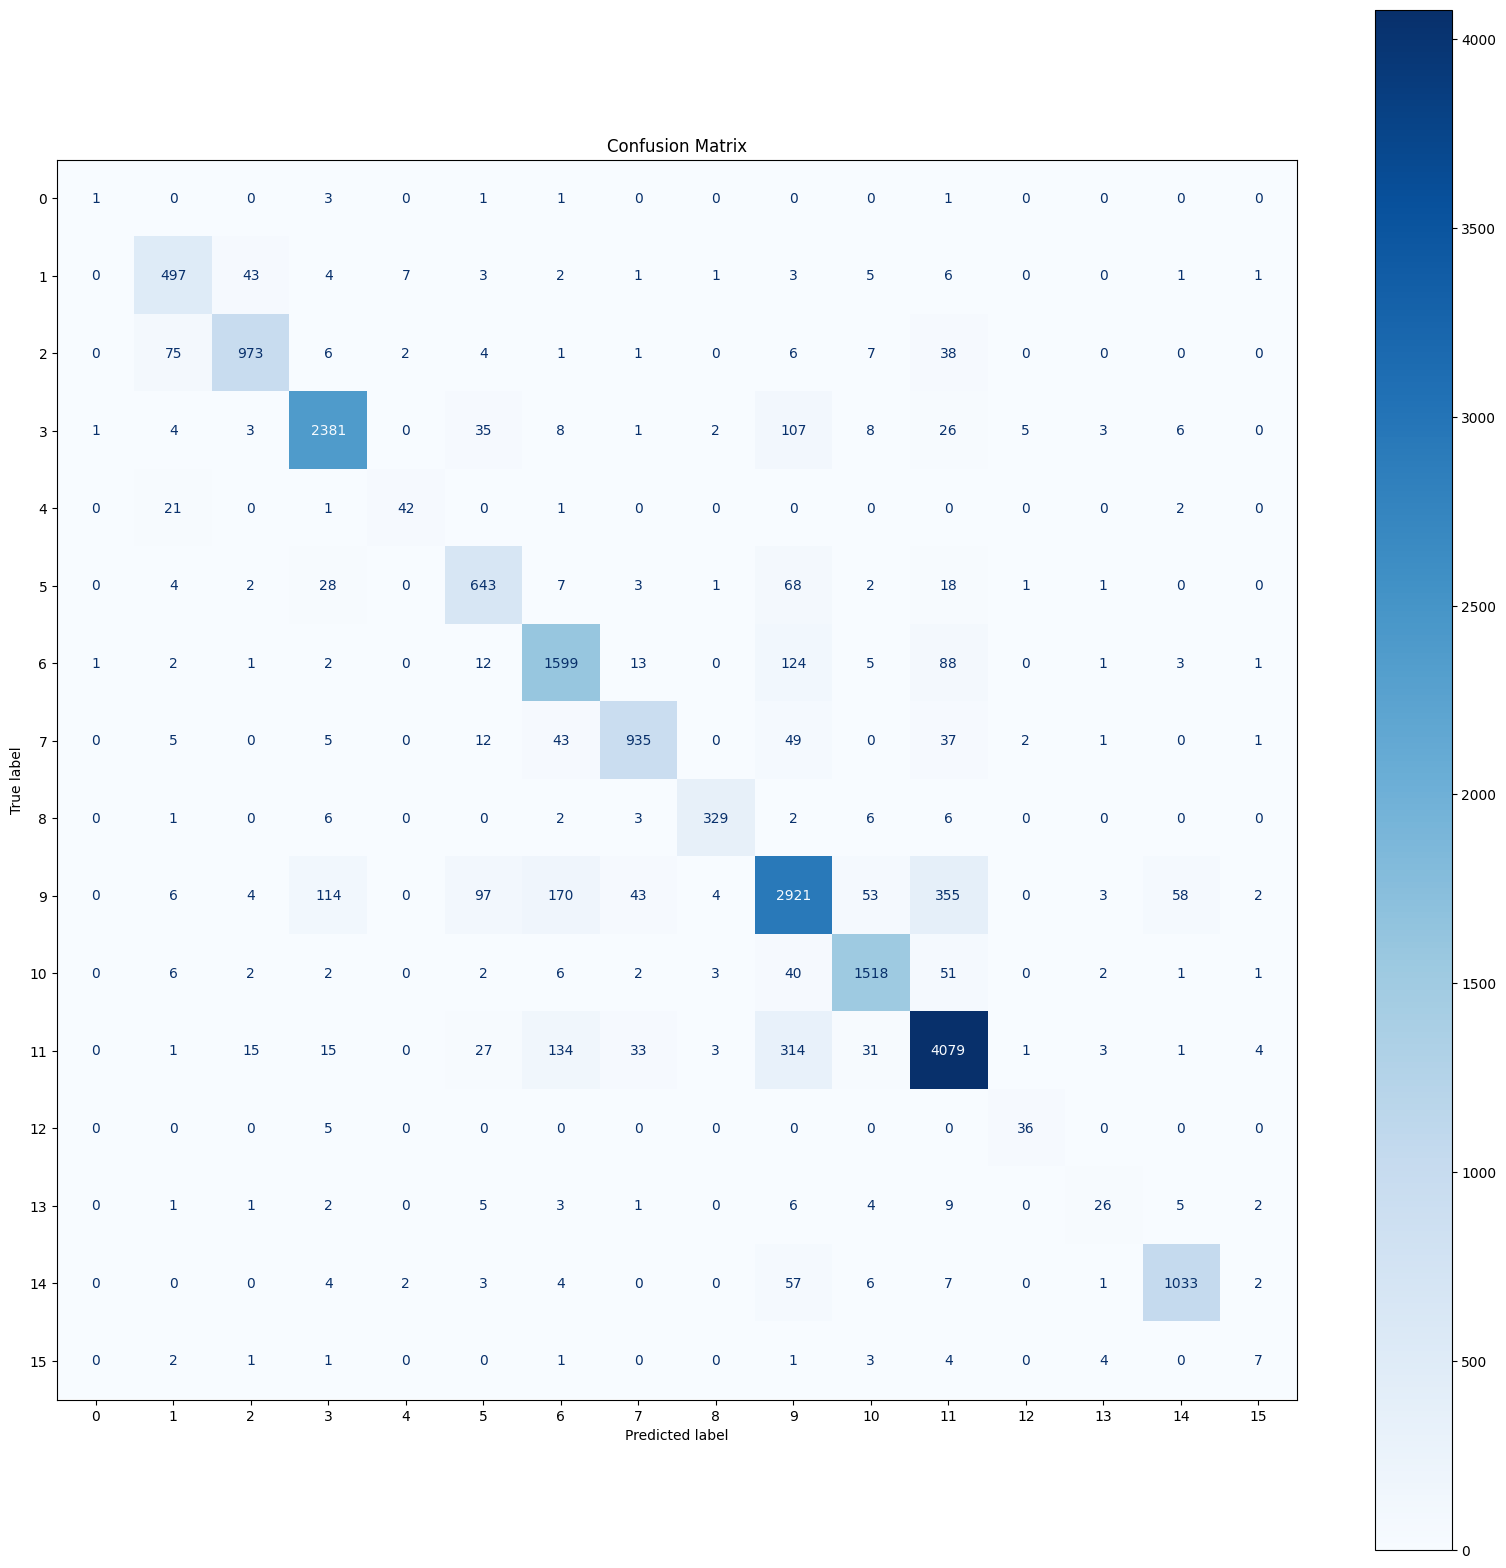

In [26]:
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=range(NUM_CLASSES))

fig, ax = plt.subplots(figsize=(20, 20))
disp.plot(cmap=plt.cm.Blues, ax=ax)

plt.title("Confusion Matrix")
# save the figure
plt.savefig('confusion_matrix.png')
plt.show()


In [ ]:
from datetime import datetime, timedelta


one_year_ago_timestamp = int((datetime.now() - timedelta(days=365)).timestamp())
total_products = products.count_documents({
    "$and": [
        {"product_name": {"$ne": ""}},  # Exclure les produits sans nom
        {"ingredients_text": {"$ne": ""}},  # Exclure les produits sans ingrédients
        {"$or": [
            {"last_updated_t": {"$exists": False}},  # Inclure si la clé n'existe pas
            {"last_updated_t": {"$gte": one_year_ago_timestamp}}  # Ou inclure si mis à jour il y a moins d'un an
        ]}
    ]
})
print(f"Total de produits à traiter : {total_products}")



Total de produits à traiter : 3058854


In [ ]:
from ProductDataset import ProductDataset
import torch, json
import pandas as pd
from torch.utils.data import DataLoader

# Fonction de préparation des tokens
def prepare_tokens(df_products: pd.DataFrame) -> pd.DataFrame:
    df_products = df_products.dropna(subset=['product_name'])
    df_products['ingredients_text'] = df_products['ingredients_text'].fillna('')
    df_products['categories'] = df_products['categories'].combine_first(df_products['categories_old'])
    df_products = df_products.drop(columns=['categories_old'])
    df_products["categories"] = df_products['categories'].fillna('')

    df_products["product_name_tokens"] = df_products["product_name"].apply(tokenize_and_remove_stopwords)
    df_products["ingredients_tokens"] = df_products["ingredients_text"].apply(tokenize_and_remove_stopwords)
    df_products["category_tokens"] = df_products["categories"].apply(tokenize_and_remove_stopwords)
    df_products = df_products[df_products['ingredients_tokens'].apply(lambda x: len(x) >= 1)]
    return df_products

# Tokenisation et transformation en indices
def transform_to_tensor(df_products: pd.DataFrame) -> pd.DataFrame:
    df_products['product_name_indices'] = df_products['product_name_tokens'].apply(lambda x: tokens_to_indices(x, vocab, MAX_LEN_PRODUCT_NAME))
    df_products['ingredients_indices'] = df_products['ingredients_tokens'].apply(lambda x: tokens_to_indices(x, vocab, MAX_LEN_INGREDIENTS))
    df_products['category_indices'] = df_products['category_tokens'].apply(lambda x: tokens_to_indices(x, vocab, MAX_LEN_CATEGORY))
    return df_products

# Créer le DataLoader pour les prédictions
def create_tensor_dataset(df_products: pd.DataFrame, vocab_size: int) -> DataLoader:
    df_products['category_idx'] = 0
    dataset = ProductDataset(
        X=df_products,
        y=df_products['category_idx'], 
        VOCAB_SIZE=vocab_size
    )
    prediction_dataloader = DataLoader(dataset, batch_size=32, shuffle=False)
    return prediction_dataloader

# Charger la correspondance des catégories
with open('../data/category_to_index.json', 'r', encoding='utf-8') as json_file:
    category_mapping = json.load(json_file)
    
category_mapping = {v: k for k, v in category_mapping.items()}


pred_collection = db["predicted_categories_v2"]

last_id = None
CHUNK_SIZE = 150000
all_results = []
total_len = 0

for _ in range(0, total_products, CHUNK_SIZE):
    query = {
        "$and": [
            {"product_name": {"$ne": ""}},
            {"ingredients_text": {"$ne": ""}},
            {"$or": [
                {"last_updated_t": {"$exists": False}},
                {"last_updated_t": {"$gte": one_year_ago_timestamp}}
            ]}
        ]
    }

    if last_id:
        query["_id"] = {"$gt": last_id}
    product_chunk = products.find(query, {"product_name": 1, "ingredients_text": 1, '_id': 1, "categories_old": 1, "categories": 1}).limit(CHUNK_SIZE)
    
    data__ = pd.DataFrame(list(product_chunk))
    if data__.empty:
        print("No more products to process")
        break

    if 'product_name' not in data__.columns or 'ingredients_text' not in data__.columns:
        print("No product_name or ingredients_text columns found")
        last_id = data__['_id'].iloc[-1]
        continue
    
    df_products = prepare_tokens(data__)
    df_products = transform_to_tensor(df_products)

    prediction_dataloader = create_tensor_dataset(df_products, VOCAB_SIZE)
    
    predictions = []
    product_ids = df_products['_id'].tolist()
    product_names = df_products['product_name'].tolist()

    with torch.no_grad():
        for batch in prediction_dataloader:
            product_name_indices = batch['product_name'].to(device)
            ingredients_indices = batch['ingredients'].to(device)
            category_indices = batch['category'].to(device)

            outputs = model(product_name_indices, ingredients_indices, category_indices)

            _, predicted = torch.max(outputs, 1)
            predictions.extend(predicted.cpu().numpy())

    predicted_categories = [category_mapping[pred] for pred in predictions]

    for _id, name, category in zip(product_ids, product_names, predicted_categories):
        all_results.append({
            'codebar': _id,
            'product_name': name,
            'predicted_category': category
        })
    
    total_len += len(df_products)
    
    if all_results:
        #pred_collection.insert_many(all_results)
        all_results.clear()
    
    last_id = product_ids[-1]
    print(f"\rProcessed {total_len}/{total_products} products", end="")


C:\Users\Azz\AppData\Local\Temp\ipykernel_1248\2360575031.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_products['ingredients_text'] = df_products['ingredients_text'].fillna('')
C:\Users\Azz\AppData\Local\Temp\ipykernel_1248\2360575031.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_products['categories'] = df_products['categories'].combine_first(df_products['categories_old'])


Processed 138510/3058854 products

C:\Users\Azz\AppData\Local\Temp\ipykernel_1248\2360575031.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_products['ingredients_text'] = df_products['ingredients_text'].fillna('')
C:\Users\Azz\AppData\Local\Temp\ipykernel_1248\2360575031.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_products['categories'] = df_products['categories'].combine_first(df_products['categories_old'])


Processed 189022/3058854 products

C:\Users\Azz\AppData\Local\Temp\ipykernel_1248\2360575031.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_products['ingredients_text'] = df_products['ingredients_text'].fillna('')
C:\Users\Azz\AppData\Local\Temp\ipykernel_1248\2360575031.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_products['categories'] = df_products['categories'].combine_first(df_products['categories_old'])


Processed 238661/3058854 products

C:\Users\Azz\AppData\Local\Temp\ipykernel_1248\2360575031.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_products['ingredients_text'] = df_products['ingredients_text'].fillna('')
C:\Users\Azz\AppData\Local\Temp\ipykernel_1248\2360575031.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_products['categories'] = df_products['categories'].combine_first(df_products['categories_old'])


Processed 258608/3058854 products

C:\Users\Azz\AppData\Local\Temp\ipykernel_1248\2360575031.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_products['ingredients_text'] = df_products['ingredients_text'].fillna('')
C:\Users\Azz\AppData\Local\Temp\ipykernel_1248\2360575031.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_products['categories'] = df_products['categories'].combine_first(df_products['categories_old'])


Processed 311960/3058854 products

C:\Users\Azz\AppData\Local\Temp\ipykernel_1248\2360575031.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_products['ingredients_text'] = df_products['ingredients_text'].fillna('')
C:\Users\Azz\AppData\Local\Temp\ipykernel_1248\2360575031.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_products['categories'] = df_products['categories'].combine_first(df_products['categories_old'])


Processed 380002/3058854 products

C:\Users\Azz\AppData\Local\Temp\ipykernel_1248\2360575031.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_products['ingredients_text'] = df_products['ingredients_text'].fillna('')
C:\Users\Azz\AppData\Local\Temp\ipykernel_1248\2360575031.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_products['categories'] = df_products['categories'].combine_first(df_products['categories_old'])


Processed 435221/3058854 products

C:\Users\Azz\AppData\Local\Temp\ipykernel_1248\2360575031.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_products['ingredients_text'] = df_products['ingredients_text'].fillna('')
C:\Users\Azz\AppData\Local\Temp\ipykernel_1248\2360575031.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_products['categories'] = df_products['categories'].combine_first(df_products['categories_old'])


Processed 476095/3058854 products

C:\Users\Azz\AppData\Local\Temp\ipykernel_1248\2360575031.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_products['ingredients_text'] = df_products['ingredients_text'].fillna('')
C:\Users\Azz\AppData\Local\Temp\ipykernel_1248\2360575031.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_products['categories'] = df_products['categories'].combine_first(df_products['categories_old'])


Processed 520658/3058854 products

C:\Users\Azz\AppData\Local\Temp\ipykernel_1248\2360575031.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_products['ingredients_text'] = df_products['ingredients_text'].fillna('')
C:\Users\Azz\AppData\Local\Temp\ipykernel_1248\2360575031.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_products['categories'] = df_products['categories'].combine_first(df_products['categories_old'])


Processed 560714/3058854 products

C:\Users\Azz\AppData\Local\Temp\ipykernel_1248\2360575031.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_products['ingredients_text'] = df_products['ingredients_text'].fillna('')
C:\Users\Azz\AppData\Local\Temp\ipykernel_1248\2360575031.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_products['categories'] = df_products['categories'].combine_first(df_products['categories_old'])


Processed 599627/3058854 products

C:\Users\Azz\AppData\Local\Temp\ipykernel_1248\2360575031.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_products['ingredients_text'] = df_products['ingredients_text'].fillna('')
C:\Users\Azz\AppData\Local\Temp\ipykernel_1248\2360575031.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_products['categories'] = df_products['categories'].combine_first(df_products['categories_old'])


Processed 634808/3058854 products

C:\Users\Azz\AppData\Local\Temp\ipykernel_1248\2360575031.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_products['ingredients_text'] = df_products['ingredients_text'].fillna('')
C:\Users\Azz\AppData\Local\Temp\ipykernel_1248\2360575031.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_products['categories'] = df_products['categories'].combine_first(df_products['categories_old'])


Processed 682761/3058854 products

C:\Users\Azz\AppData\Local\Temp\ipykernel_1248\2360575031.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_products['ingredients_text'] = df_products['ingredients_text'].fillna('')
C:\Users\Azz\AppData\Local\Temp\ipykernel_1248\2360575031.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_products['categories'] = df_products['categories'].combine_first(df_products['categories_old'])


Processed 705884/3058854 products

C:\Users\Azz\AppData\Local\Temp\ipykernel_1248\2360575031.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_products['ingredients_text'] = df_products['ingredients_text'].fillna('')
C:\Users\Azz\AppData\Local\Temp\ipykernel_1248\2360575031.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_products['categories'] = df_products['categories'].combine_first(df_products['categories_old'])


Processed 727657/3058854 products

C:\Users\Azz\AppData\Local\Temp\ipykernel_1248\2360575031.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_products['ingredients_text'] = df_products['ingredients_text'].fillna('')
C:\Users\Azz\AppData\Local\Temp\ipykernel_1248\2360575031.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_products['categories'] = df_products['categories'].combine_first(df_products['categories_old'])


Processed 765628/3058854 products

C:\Users\Azz\AppData\Local\Temp\ipykernel_1248\2360575031.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_products['ingredients_text'] = df_products['ingredients_text'].fillna('')
C:\Users\Azz\AppData\Local\Temp\ipykernel_1248\2360575031.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_products['categories'] = df_products['categories'].combine_first(df_products['categories_old'])


Processed 795644/3058854 productsNo product_name or ingredients_text columns found
No more products to process
